In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn import preprocessing
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
DATA_DIR = "~/jupyter_notebooks/DATA/MarchMadness"

In [3]:
# https://www.kaggle.com/c/ncaam-march-mania-2021/data
teams_df = pd.read_csv(f"{DATA_DIR}/MTeams.csv")
seeds_df = pd.read_csv(f"{DATA_DIR}/MNCAATourneySeeds.csv")
reg_results_df = pd.read_csv(f"{DATA_DIR}/MRegularSeasonDetailedResults.csv")
tournament_results_df = pd.read_csv(f"{DATA_DIR}/MNCAATourneyCompactResults.csv")

In [4]:
STATS = {
    'Score',
    'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA',
    'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF'    
}

SHARED = {
    'Season', 'DayNum', 'NumOT'
}

In [5]:
# Split single W & L row into two rows, one for winner one for loser
games = reg_results_df.to_dict('records')
games_dicts = []
for game in tqdm(games):
    game["LLoc"] = "H" if game["WLoc"] == "A" else "A"
    game["WLoc"] = game["WLoc"] if game["WLoc"] != "N" else "A"
    both_dict = {
        k: v
        for k, v in game.items()
        if k in SHARED
    }
    w_own_dict = {
        f"Own{k[1:]}": v
        for k, v in game.items()
        if k.startswith("W") and k not in SHARED
    }
    w_opp_dict = {
        f"Opp{k[1:]}": v
        for k, v in game.items()
        if k.startswith("L") and k not in SHARED
    }
    l_own_dict = {
        f"Own{k[1:]}": v
        for k, v in game.items()
        if k.startswith("L") and k not in SHARED
    }
    l_opp_dict = {
        f"Opp{k[1:]}": v
        for k, v in game.items()
        if k.startswith("W") and k not in SHARED
    }
    w_dict = {**both_dict, **w_own_dict, **w_opp_dict, **{"OppTeamID": game["LTeamID"]}}
    l_dict = {**both_dict, **l_own_dict, **l_opp_dict, **{"OppTeamID": game["WTeamID"]}}
    games_dicts.append(w_dict)
    games_dicts.append(l_dict)

100%|██████████| 92832/92832 [00:03<00:00, 25979.85it/s]


In [6]:
# Calculate each teams home and away season averages
games_df = pd.DataFrame(games_dicts)
mean_df = games_df.groupby(["Season", "OwnTeamID", "OwnLoc"]).mean().drop(["DayNum", "NumOT", "OppTeamID"], axis=1)
std_df = games_df.groupby(["Season", "OwnTeamID", "OwnLoc"]).std().drop(["DayNum", "NumOT", "OppTeamID"], axis=1)

In [7]:
def flip_key(key):
    if key.startswith("Own"):
        return key.replace("Own", "Opp")
    if key.startswith("Opp"):
        return key.replace("Opp", "Own")
    raise ValueError

In [8]:
# Calculate z scores for each game for:
# 1) opp performance (how did my opp do relative to how they do against others?)
# 2) own performance (how did I do relative to how others do against my opp?)
z_dicts = []
opp_keys = [k for k in games_dicts[0].keys() if k.startswith("Opp") and k in mean_df.columns]
own_keys = [k for k in games_dicts[0].keys() if k.startswith("Own") and k in mean_df.columns]
for game in tqdm(games_dicts):
    means = mean_df.loc[(game["Season"], game["OppTeamID"], game["OppLoc"])]
    stds = std_df.loc[(game["Season"], game["OppTeamID"], game["OppLoc"])]
    both_dict = {
        k: v
        for k, v in game.items()
        if k in SHARED
    }
    opp_stat_dict = {
        f"{k}_Zscore": (
            game[k] - means[flip_key(k)]
        ) / (
            stds[flip_key(k)]
        )
        for k in opp_keys
    }
    own_stat_dict = {
        f"{k}_Zscore": (
            game[k] - means[flip_key(k)]
        ) / (
            stds[flip_key(k)]
        )
        for k in own_keys
    }
    z_dicts.append({
        **both_dict, **own_stat_dict, **opp_stat_dict,
         **{"OwnTeamID": game["OwnTeamID"], "OppTeamID": game["OppTeamID"]}
    })

 21%|██        | 39069/185664 [00:11<00:44, 3294.13it/s]<ipython-input-8-200af332dc19>:16: RuntimeWarning: invalid value encountered in double_scalars
  f"{k}_Zscore": (
100%|██████████| 185664/185664 [00:56<00:00, 3289.89it/s]


In [9]:
# Get season average z scores
z_df = pd.DataFrame(z_dicts)
z_score_mean_df = z_df.groupby(["Season", "OwnTeamID"]).mean().drop(["DayNum", "NumOT", "OppTeamID"], axis=1)
z_score_mean_df

OwnScore_Zscore  OwnFGM_Zscore  OwnFGA_Zscore  \
Season OwnTeamID                                                  
2003   1102             -1.127532      -1.253202      -1.833543   
       1103              0.539325       0.435770       0.122903   
       1104              0.144799       0.075951       0.284126   
       1105             -0.024473      -0.197995       0.451216   
       1106             -0.632613      -0.363108      -0.387317   
...                           ...            ...            ...   
2020   1463              0.494157       0.299524      -0.045459   
       1464             -0.105439      -0.010592       0.349589   
       1465              0.321987       0.130451       0.464548   
       1466             -0.075846      -0.391120      -0.407716   
       1467             -0.857837      -0.802729      -0.782069   

                  OwnFGM3_Zscore  OwnFGA3_Zscore  OwnFTM_Zscore  \
Season OwnTeamID                                                  
2003   1102             0.477041        0.522299      -0.741342   
       1103            -0.318710       -0.276568       0.513936   
       1104             0.113584        0.394190       0.244045   
       1105             0.464701        0.461980       0.060907   
       1106            -0.072352       -0.172450      -0.612042   
...                          ...             ...            ...   
2020   1463             0.584217        0.446733       0.143025   
       1464            -0.060058        0.165211      -0.174452   
       1465             0.787093        0.853269       0.080038   
       1466            -0.117749       -0.353728       0.572743   
       1467            -0.015196        0.074701      -0.483522   

                  OwnFTA_Zscore  OwnOR_Zscore  OwnDR_Zscore  OwnAst_Zscore  \
Season OwnTeamID                                                             
2003   1102           -0.667528     -1.602939     -1.229258      -0.218539   
       1103            0.348426     -0.334213     -0.582446       0.492432   
       1104            0.192006      0.539229      0.434924      -0.226316   
       1105           -0.080341      0.139286     -0.304837       0.250561   
       1106           -0.603919     -0.148308     -0.158943      -0.555171   
...                         ...           ...           ...            ...   
2020   1463            0.126813     -0.239092      0.734628       0.612153   
       1464           -0.155008      0.718603     -0.155213      -0.283529   
       1465           -0.107278      0.407892      0.517194      -0.060693   
       1466            0.683003      0.007472      0.132149      -0.547681   
       1467           -0.459102     -0.652164     -1.013043      -0.250565   

                  ...  OppFGA3_Zscore  OppFTM_Zscore  OppFTA_Zscore  \
Season OwnTeamID  ...                                                 
2003   1102       ...       -0.943790      -0.296616      -0.334020   
       1103       ...        0.042869       0.007201      -0.088038   
       1104       ...        0.209538      -0.186678      -0.278912   
       1105       ...       -0.226223       0.409058       0.469569   
       1106       ...       -0.756056       0.217710       0.151650   
...               ...             ...            ...            ...   
2020   1463       ...        0.235455      -0.181846      -0.223989   
       1464       ...       -0.382612      -0.211769      -0.212786   
       1465       ...       -0.224185      -0.065136      -0.008589   
       1466       ...       -0.373100       0.445614       0.549617   
       1467       ...       -1.168171       0.132524       0.126491   

                  OppOR_Zscore  OppDR_Zscore  OppAst_Zscore  OppTO_Zscore  \
Season OwnTeamID                                                            
2003   1102          -0.519117     -0.537864      -1.015983     -0.420790   
       1103           0.166664     -0.156222       0.555678      0.141952   
       1104          -0.214

In [10]:
def build_pca(n, df):
    data_scaled = pd.DataFrame(preprocessing.scale(df), columns=df.columns) 
    pca = PCA(n_components=n)
    results = pca.fit_transform(data_scaled)
    return pca, results

In [11]:
# PCA
PCA_N = 2
pca, results = build_pca(n=PCA_N, df=z_score_mean_df)    
pca_df = pd.DataFrame(
    pca.components_,
    columns=z_score_mean_df.columns,
    index= [f'PCA-{n}' for n in range(PCA_N)]
)
for i in range(PCA_N):
    print(pca_df.T.sort_values(by=f"PCA-{i}", key=abs, ascending=False)[:5][f"PCA-{i}"])
    print()

OwnFGA_Zscore      0.302463
OppScore_Zscore    0.298161
OppFGA_Zscore      0.291517
OppFGM_Zscore      0.260614
OwnScore_Zscore    0.252161
Name: PCA-0, dtype: float64

OwnScore_Zscore   -0.326426
OwnFGM_Zscore     -0.313468
OwnAst_Zscore     -0.292864
OwnDR_Zscore      -0.277547
OppFTM_Zscore      0.266493
Name: PCA-1, dtype: float64



In [12]:
# Dominance & Competition
z_score_mean_df["Offense"] = z_score_mean_df["OwnScore_Zscore"] + z_score_mean_df["OppScore_Zscore"]
z_score_mean_df["Dominance"] = z_score_mean_df["OwnScore_Zscore"] - z_score_mean_df["OppScore_Zscore"]

def set_competition_scores(off_col, def_col):
    comp_scores = []
    for game in games_dicts:
        comp_scores.append({
            "Season": game["Season"],
            "TeamID": game["OwnTeamID"],
            "OffCompetition": z_score_mean_df.at[(game["Season"], game["OppTeamID"]), off_col]
        })
    comp_df = pd.DataFrame(comp_scores).groupby(["Season", "TeamID"]).mean()
    z_score_mean_df["OffCompetition"] = comp_df["OffCompetition"]

    comp_scores = []
    for game in games_dicts:
        comp_scores.append({
            "Season": game["Season"],
            "TeamID": game["OwnTeamID"],
            "DefCompetition": z_score_mean_df.at[(game["Season"], game["OppTeamID"]), def_col]
        })
    comp_df = pd.DataFrame(comp_scores).groupby(["Season", "TeamID"]).mean()
    z_score_mean_df["DefCompetition"] = comp_df["DefCompetition"]
    z_score_mean_df["Competition"] = z_score_mean_df["OffCompetition"] - z_score_mean_df["DefCompetition"]

set_competition_scores("OwnScore_Zscore", "OppScore_Zscore")
for i in tqdm(range(2)):
    set_competition_scores("OffCompetition", "DefCompetition")

100%|██████████| 2/2 [00:08<00:00,  4.26s/it]


In [14]:
summary_df = z_score_mean_df.reset_index().rename(columns={"OwnTeamID": "TeamID"})[[
    "Season", "TeamID", 
    "OwnScore_Zscore", "OppScore_Zscore",
    "Offense", "Dominance", "Competition",
    "OffCompetition", "DefCompetition",
]]
summary_df

,Season,TeamID,OwnScore_Zscore,OppScore_Zscore,Offense,Dominance,Competition,OffCompetition,DefCompetition
0,2003,1102,-1.127532,-1.201184,-2.328716,0.073652,0.016740,0.016065,-0.000675
1,2003,1103,0.539325,0.569464,1.108789,-0.030139,-0.002847,0.014923,0.017770
2,2003,1104,0.144799,-0.335313,-0.190514,0.480112,0.153344,0.066613,-0.086731
3,2003,1105,-0.024473,0.603600,0.579127,-0.628073,-0.170366,-0.078793,0.091573
4,2003,1106,-0.632613,-0.607981,-1.240594,-0.024632,-0.162305,-0.070382,0.091923
...,...,...,...,...,...,...,...,...,...
6182,2020,1463,0.494157,-0.262746,0.231411,0.756903,-0.007617,-0.008356,-0.000738
6183,2020,1464,-0.105439,0.096059,-0.009380,-0.201498,-0.085371,-0.026838,0.058533
6184,2020,1465,0.321987,0.261965,0.583951,0.060022,-0.104033,-0.060144,0.043889
6185,2020,1466,-0.075846,0.222811,0.146964,-0.298657,-0.067387,-0.053262,0.014126


In [15]:
# Get tournament wins per team
FIRST_ROUND_CUTOFF = 136
results_df = tournament_results_df[tournament_results_df["DayNum"] >= FIRST_ROUND_CUTOFF]
win_count_df = results_df.groupby(["Season", "WTeamID"]).count().reset_index()[["Season", "WTeamID", "DayNum"]]
win_count_df = win_count_df.rename(columns={"WTeamID": "TeamID", "DayNum": "Wins"})
win_count_df

,Season,TeamID,Wins
0,1985,1104,2
1,1985,1116,1
2,1985,1120,2
3,1985,1130,2
4,1985,1181,1
...,...,...,...
1115,2019,1437,1
1116,2019,1438,6
1117,2019,1439,2
1118,2019,1449,1


In [16]:
# Cast seed to int
def get_seed_int(seed):
    numeric_filter = filter(str.isdigit, seed)
    return int("".join(numeric_filter))

seeds_df["SeedInt"] = seeds_df["Seed"].apply(get_seed_int)

In [17]:
# Merge into master DF
tournament_df = teams_df.merge(seeds_df, on="TeamID")[["Season", "TeamID", "TeamName", "Seed", "SeedInt"]]
tournament_df = tournament_df.merge(summary_df, on=["Season", "TeamID"])
tournament_df = tournament_df.merge(win_count_df, on=["Season", "TeamID"], how="left").fillna(0)
is_champion = tournament_df["Wins"] >= 6

In [18]:
def scatter_text(x, y, labelseries, labelsize='large', labelcolor='black', **kwargs):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(x=x, y=y, **kwargs)
    # Add text besides each point
    offset = 0.01 * (max(x) - min(x))
    for index in range(len(x)):
         p1.text(
             x.iloc[index]+offset, y.iloc[index], 
             labelseries.iloc[index], size=labelsize, color=labelcolor
         )
    return p1

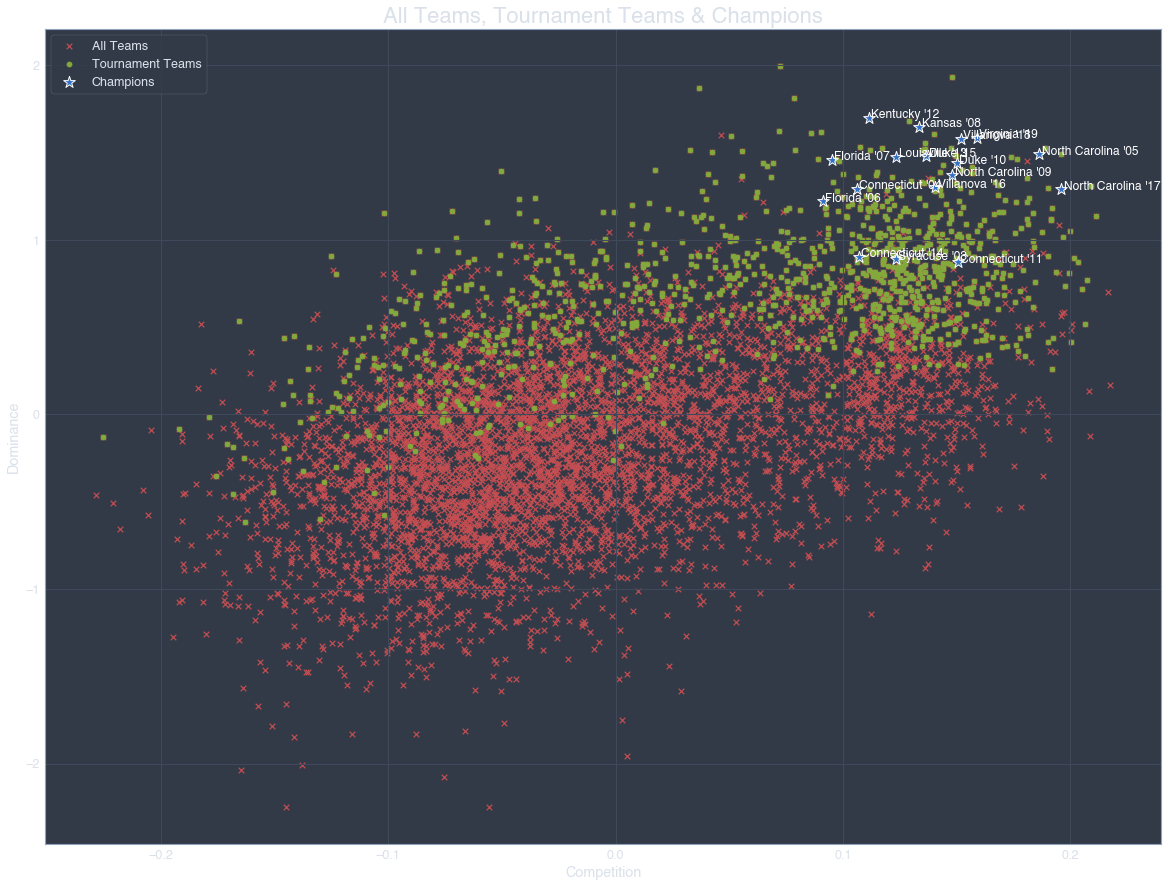

In [20]:
label_series = (
    tournament_df[is_champion]["TeamName"] + " '" +
    tournament_df[is_champion]["Season"].astype(str).str[-2:]
)

plt.figure(figsize=(20,15));
plt.title("All Teams, Tournament Teams & Champions", fontsize=22)
plt.scatter(summary_df["Competition"], summary_df["Dominance"], color='r', marker='x', label='All Teams');
plt.scatter(tournament_df["Competition"], tournament_df["Dominance"], color='g', label='Tournament Teams');
scatter_text(
    tournament_df[is_champion]["Competition"], tournament_df[is_champion]["Dominance"],
    color='b', marker='*', s=150, label='Champions',
    labelseries=label_series,
    labelcolor='white'
);
plt.legend(loc='upper left');

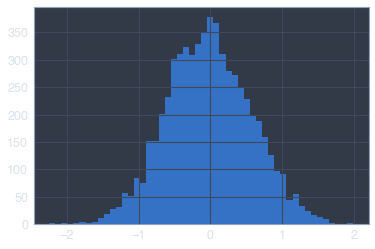

In [21]:
# Dominance follows a normal curve
plt.hist(summary_df["Dominance"], bins=50);

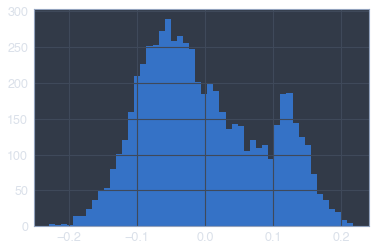

In [22]:
# Competition is a mix of two bell curves (one for elite teams and one for the rest)
plt.hist(summary_df["Competition"], bins=50);

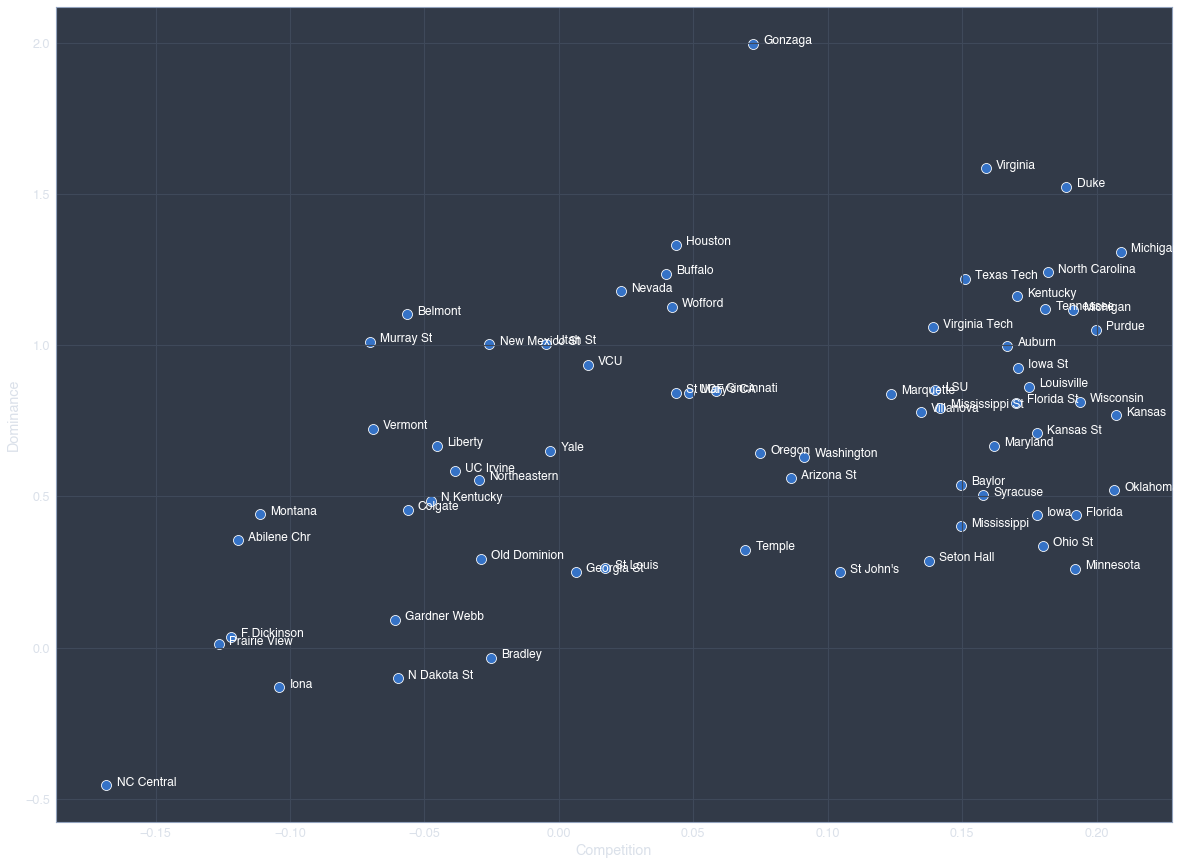

In [23]:
YEAR = 2019
is_year = tournament_df["Season"] == YEAR
plt.figure(figsize=(20,15));
scatter_text(
    x=tournament_df[is_year]["Competition"], y=tournament_df[is_year]["Dominance"], s=100,
    labelseries=tournament_df[is_year]["TeamName"], labelcolor="white"
);

In [24]:
# Top 25 Dominant teams
tournament_df.sort_values("Dominance", ascending=False)[:25]

,Season,TeamID,TeamName,Seed,SeedInt,OwnScore_Zscore,OppScore_Zscore,Offense,Dominance,Competition,OffCompetition,DefCompetition,Wins
305,2019,1211,Gonzaga,X01,1,1.398097,-0.598454,0.799643,1.996552,0.072340,0.032873,-0.039467,3.0
403,2015,1246,Kentucky,Y01,1,0.743464,-1.188320,-0.444856,1.931784,0.148082,0.074185,-0.073898,4.0
303,2017,1211,Gonzaga,X01,1,1.066522,-0.804608,0.261915,1.871130,0.036718,0.001615,-0.035103,5.0
434,2014,1257,Louisville,Y04,4,1.078797,-0.731865,0.346932,1.810663,0.078249,0.039047,-0.039201,2.0
401,2012,1246,Kentucky,Y01,1,0.912072,-0.785912,0.126161,1.697984,0.111291,0.048349,-0.062942,6.0
371,2010,1242,Kansas,Y01,1,0.921894,-0.758095,0.163799,1.679989,0.128992,0.087737,-0.041255,1.0
369,2008,1242,Kansas,X01,1,1.024545,-0.621341,0.403204,1.645886,0.133529,0.063800,-0.069729,6.0
299,2013,1211,Gonzaga,Z01,1,0.868779,-0.752179,0.116601,1.620958,0.071845,0.043515,-0.028330,1.0
248,2013,1196,Florida,X03,3,0.479926,-1.138982,-0.659056,1.618908,0.090429,0.038868,-0.051561,3.0
301,2015,1211,Gonzaga,X02,2,0.963646,-0.650415,0.313231,1.614061,0.085979,0.050443,-0.035535,3.0


In [25]:
tournament_df.to_csv(f"{DATA_DIR}/output/teams.csv", index=False)

In [26]:
reg_results_df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92827,2020,128,1389,56,1233,54,N,0,15,60,...,16,18,20,4,27,6,17,8,4,20
92828,2020,128,1393,81,1314,53,N,0,28,61,...,16,11,13,13,29,9,18,0,1,18
92829,2020,128,1402,85,1111,68,H,0,34,57,...,15,25,35,8,17,6,18,7,2,18
92830,2020,128,1412,74,1427,69,N,0,26,53,...,27,7,7,12,22,11,13,4,2,18


In [27]:
# Get game training data
should_use_all_games = True
merge_df = summary_df if should_use_all_games else tournament_df

FEATURE_COLS = [
    "OwnScore_Zscore", "OppScore_Zscore",
    "Offense", "Dominance", "Competition",
    "OffCompetition", "DefCompetition",
]

def get_training_df(feature_cols):
    TOURNAMENT_COLS = ["Season", "TeamID"] + feature_cols

    training_df = reg_results_df.merge(
        merge_df[TOURNAMENT_COLS],
        left_on=["Season", "WTeamID"],
        right_on=["Season", "TeamID"]
    ).rename(columns={k: f"W{k}" for k in feature_cols}).drop("TeamID", axis=1)

    training_df = training_df.merge(
        merge_df[TOURNAMENT_COLS],
        left_on=["Season", "LTeamID"],
        right_on=["Season", "TeamID"]
    ).rename(columns={k: f"L{k}" for k in feature_cols}).drop("TeamID", axis=1)

    training_df["TeamID_A"] = training_df.apply(lambda x: min(x["WTeamID"], x["LTeamID"]), axis=1).astype(int)
    training_df["TeamID_B"] = training_df.apply(lambda x: max(x["WTeamID"], x["LTeamID"]), axis=1).astype(int)
    for col in feature_cols:   
        training_df[f"{col}_A"] = training_df.apply(
            lambda x: x[f"W{col}"] if x["TeamID_A"] == x["WTeamID"] else x[f"L{col}"], axis=1
        )
        training_df[f"{col}_B"] = training_df.apply(
            lambda x: x[f"W{col}"] if x["TeamID_B"] == x["WTeamID"] else x[f"L{col}"], axis=1
        )

    training_df["Win_A"] = training_df["TeamID_A"] == training_df["WTeamID"]

    FINAL_COLS = (
        ["Season", "TeamID_A", "TeamID_B"] + 
        [f"{col}_A" for col in feature_cols] +
        [f"{col}_B" for col in feature_cols] +
        ["Win_A"]
    )
    training_df = training_df[FINAL_COLS]
    return training_df

training_df = get_training_df(FEATURE_COLS)
training_df

,Season,TeamID_A,TeamID_B,OwnScore_Zscore_A,OppScore_Zscore_A,Offense_A,Dominance_A,Competition_A,OffCompetition_A,DefCompetition_A,OwnScore_Zscore_B,OppScore_Zscore_B,Offense_B,Dominance_B,Competition_B,OffCompetition_B,DefCompetition_B,Win_A
0,2003,1104,1328,0.144799,-0.335313,-0.190514,0.480112,0.153344,0.066613,-0.086731,0.207507,-0.863963,-0.656456,1.071470,0.138428,0.063014,-0.075414,True
1,2003,1328,1400,0.207507,-0.863963,-0.656456,1.071470,0.138428,0.063014,-0.075414,0.935597,-0.181307,0.754290,1.116904,0.147428,0.070846,-0.076583,False
2,2003,1328,1400,0.207507,-0.863963,-0.656456,1.071470,0.138428,0.063014,-0.075414,0.935597,-0.181307,0.754290,1.116904,0.147428,0.070846,-0.076583,False
3,2003,1281,1328,0.297116,-0.342031,-0.044915,0.639147,0.159710,0.080871,-0.078838,0.207507,-0.863963,-0.656456,1.071470,0.138428,0.063014,-0.075414,True
4,2003,1328,1329,0.207507,-0.863963,-0.656456,1.071470,0.138428,0.063014,-0.075414,-0.064060,-0.740947,-0.805007,0.676887,0.130400,0.057988,-0.072412,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92827,2020,1460,1464,0.580601,0.198484,0.779084,0.382117,-0.095470,-0.033763,0.061707,-0.105439,0.096059,-0.009380,-0.201498,-0.085371,-0.026838,0.058533,False
92828,2020,1227,1460,-0.313002,-0.164300,-0.477301,-0.148702,-0.071519,-0.023355,0.048164,0.580601,0.198484,0.779084,0.382117,-0.095470,-0.033763,0.061707,True
92829,2020,1227,1460,-0.313002,-0.164300,-0.477301,-0.148702,-0.071519,-0.023355,0.048164,0.580601,0.198484,0.779084,0.382117,-0.095470,-0.033763,0.061707,True
92830,2020,1232,1460,0.095964,-0.190164,-0.094200,0.286128,0.011510,-0.009144,-0.020654,0.580601,0.198484,0.779084,0.382117,-0.095470,-0.033763,0.061707,True


In [28]:
training_df.to_csv(f"{DATA_DIR}/output/games_training.csv", index=False)